In [42]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
df = pd.read_csv('data/df_feats_assembled.csv')

In [3]:
df

,userId,churn,location,agent,gender,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,...,Thumbs Up_recent,Help_recent,Upgrade_recent,Error_recent,Submit Upgrade_recent,count_recent,status_307_count_recent,get_count_recent,total_time_recent,avg_gap_time_recent
0,1662639,1,"Oxnard-Thousand Oaks-Ventura, CA",windows,M,1534024341000,0.000399,0.008112,0.035372,0.011037,...,0.036298,0.004840,0.0,0.00242,0.0,1653,0.071990,0.076830,218.820833,11.482753
1,1090823,0,"New York-Newark-Jersey City, NY-NJ-PA",windows,M,1537927525000,0.000000,0.006814,0.028109,0.009370,...,0.038986,0.000000,0.0,0.00000,0.0,513,0.066277,0.038986,235.403056,51.081319
2,1321163,0,"Birmingham-Hoover, AL",windows,M,1537817518000,0.000000,0.008943,0.032088,0.005260,...,0.047002,0.009724,0.0,0.00000,0.0,617,0.076175,0.047002,280.317500,80.715741
3,1839943,0,"Miami-Fort Lauderdale-West Palm Beach, FL",mac,F,1535904852000,0.000678,0.006784,0.044776,0.000678,...,0.031447,0.000000,0.0,0.00000,0.0,159,0.088050,0.113208,153.583056,48.526852
4,1331962,0,"Edwards, CO",windows,M,1536901904000,0.000000,0.011004,0.031637,0.009629,...,0.047753,0.014045,0.0,0.00000,0.0,356,0.084270,0.061798,208.947778,94.525000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22256,1679128,0,"San Diego-Carlsbad, CA",mac,F,1535979645000,0.000000,0.000000,0.044118,0.000000,...,0.000000,0.000000,0.0,0.00000,0.0,11,0.090909,0.181818,0.553056,0.000000
22257,1105395,0,"Minneapolis-St. Paul-Bloomington, MN-WI",windows,F,1529776594000,0.000000,0.015385,0.061538,0.000000,...,0.083333,0.000000,0.0,0.00000,0.0,12,0.166667,0.083333,0.691111,0.000000
22258,1913790,0,"Chicago-Naperville-Elgin, IL-IN-WI",mac,F,1533361992000,0.000000,0.000000,0.039683,0.000000,...,0.038462,0.000000,0.0,0.00000,0.0,26,0.115385,0.000000,1.228333,0.000000
22259,1480584,0,"Los Angeles-Long Beach-Anaheim, CA",mac,M,1537029126000,0.010000,0.040000,0.030000,0.020000,...,0.000000,0.000000,0.0,0.00000,0.0,29,0.103448,0.068966,1.246667,0.000000


### 1. baseline random forest

In [44]:
df_model = pd.get_dummies(df, columns=['agent','gender','first_level','last_level'], drop_first=True, dtype=int)
df_model.head(5)

,userId,churn,location,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,...,get_count_recent,total_time_recent,avg_gap_time_recent,agent_iphone,agent_linux,agent_mac,agent_windows,gender_M,first_level_paid,last_level_paid
0,1662639,1,"Oxnard-Thousand Oaks-Ventura, CA",1534024341000,0.000399,0.008112,0.035372,0.011037,0.011037,0.011436,...,0.076830,218.820833,11.482753,0,0,0,1,1,0,1
1,1090823,0,"New York-Newark-Jersey City, NY-NJ-PA",1537927525000,0.000000,0.006814,0.028109,0.009370,0.002129,0.009370,...,0.038986,235.403056,51.081319,0,0,0,1,1,1,1
2,1321163,0,"Birmingham-Hoover, AL",1537817518000,0.000000,0.008943,0.032088,0.005260,0.020516,0.012099,...,0.047002,280.317500,80.715741,0,0,0,1,1,0,1
3,1839943,0,"Miami-Fort Lauderdale-West Palm Beach, FL",1535904852000,0.000678,0.006784,0.044776,0.000678,0.041384,0.018318,...,0.113208,153.583056,48.526852,0,0,1,0,0,0,0
4,1331962,0,"Edwards, CO",1536901904000,0.000000,0.011004,0.031637,0.009629,0.001376,0.013755,...,0.061798,208.947778,94.525000,0,0,0,1,1,1,1


In [47]:
def do_fit(df):
    X, y = df.drop(columns=['churn', 'location']).values, df.churn.values
    feats = df.drop(columns=['churn', 'location']).columns
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    clf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                       param_grid = {'min_samples_leaf':[1,2,5,7,10,20,30]},
                       cv = ShuffleSplit(n_splits=4, random_state=42),
                       scoring = ['f1', 'roc_auc'],
                       refit = 'f1',
                       verbose = 3)
    
    clf.fit(X_train, y_train)
    
    print('best param:', clf.best_params_)
    print('f1 score on test:', f1_score(clf.predict(X_test), y_test))
    
    return clf, feats

In [48]:
clf, feats = do_fit(df_model)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.819) roc_auc: (test=0.949) total time=   6.8s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.816) roc_auc: (test=0.945) total time=   7.0s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.833) roc_auc: (test=0.960) total time=   7.1s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.821) roc_auc: (test=0.953) total time=   6.7s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.826) roc_auc: (test=0.953) total time=   6.6s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.826) roc_auc: (test=0.944) total time=   7.0s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.835) roc_auc: (test=0.960) total time=   8.7s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.830) roc_auc: (test=0.951) total time=   7.1s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.845) roc_auc: (test=0.952) total time=   6.7s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.835) roc_auc: (test=0.943) total time=   6.3s
[CV 3/4] END min_samples_leaf=

#### this is already close to 0.84, not bad at all

### 2. do something about registration, max_ts, min_ts, total_time, these are correlated

In [49]:
# make sure unit doesn't matter, which should be true!
df_model_tmp = df_model.copy()
ref_ts = df_model_tmp.registration.min()
for col in ['registration','max_ts','min_ts']:
    df_model_tmp[col] = (df_model_tmp[col] - ref_ts)/3600/1000
clf, feats = do_fit(df_model_tmp)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.818) roc_auc: (test=0.950) total time=   7.0s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.821) roc_auc: (test=0.946) total time=   6.9s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.831) roc_auc: (test=0.962) total time=   6.8s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.819) roc_auc: (test=0.952) total time=   6.9s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.831) roc_auc: (test=0.950) total time=   6.7s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.833) roc_auc: (test=0.940) total time=   6.6s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.834) roc_auc: (test=0.959) total time=   6.7s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.829) roc_auc: (test=0.952) total time=   6.7s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.846) roc_auc: (test=0.954) total time=   6.3s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.830) roc_auc: (test=0.943) total time=   6.3s
[CV 3/4] END min_samples_leaf=

<Axes: xlabel='registration', ylabel='Density'>

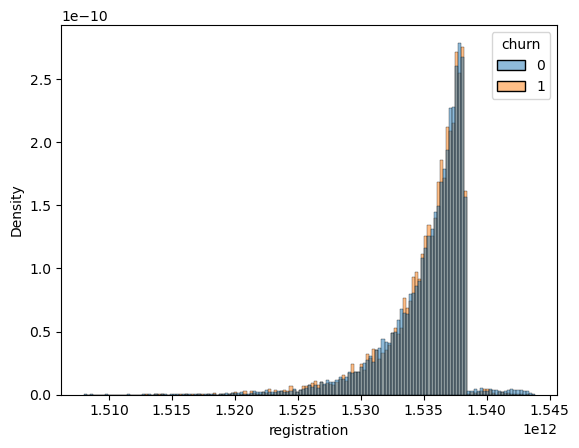

In [54]:
sns.histplot(df_model, x='registration', hue='churn', common_norm=False, stat='density')

In [55]:
df_model_tmp = df_model.drop(columns='registration')
clf, feats = do_fit(df_model_tmp)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.816) roc_auc: (test=0.953) total time=   6.5s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.826) roc_auc: (test=0.940) total time=   6.5s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.828) roc_auc: (test=0.958) total time=   6.5s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.820) roc_auc: (test=0.948) total time=   6.6s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.834) roc_auc: (test=0.952) total time=   6.3s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.829) roc_auc: (test=0.944) total time=   6.4s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.837) roc_auc: (test=0.958) total time=   6.4s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.821) roc_auc: (test=0.953) total time=   6.4s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.843) roc_auc: (test=0.952) total time=   6.1s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.838) roc_auc: (test=0.944) total time=   6.1s
[CV 3/4] END min_samples_leaf=

#### dropping registration seems fine

<Axes: xlabel='min_ts', ylabel='Density'>

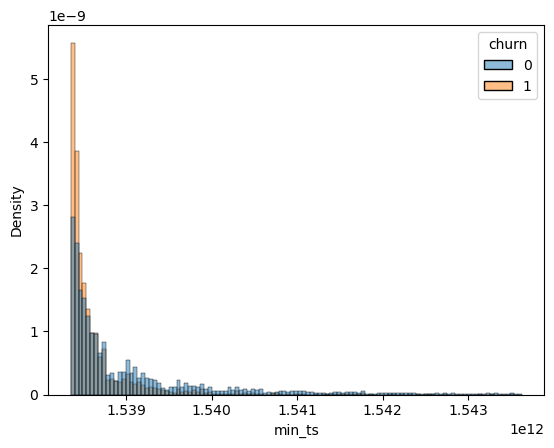

In [56]:
sns.histplot(df_model, x='min_ts', hue='churn', common_norm=False, stat='density')

In [61]:
df_model_tmp = df_model.copy()
df_model_tmp['min_ts_since_registration'] = df_model_tmp['min_ts'] - df_model_tmp['registration']
df_model_tmp['max_ts_since_registration'] = df_model_tmp['max_ts'] - df_model_tmp['registration']
df_model_tmp.drop(columns=['registration','min_ts','max_ts'], inplace=True)

<Axes: xlabel='min_ts_since_registration', ylabel='Density'>

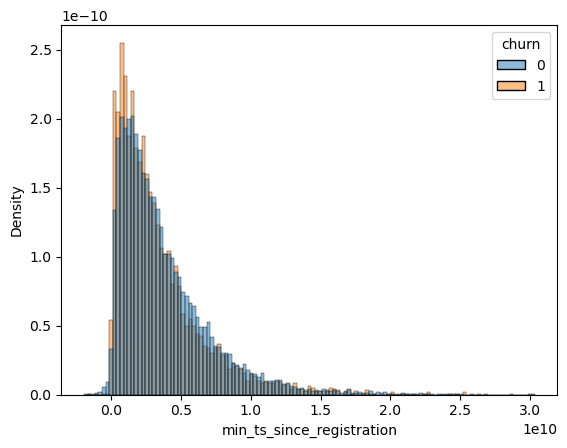

In [62]:
sns.histplot(df_model_tmp, x='min_ts_since_registration', hue='churn', common_norm=False, stat='density')

<Axes: xlabel='max_ts_since_registration', ylabel='Density'>

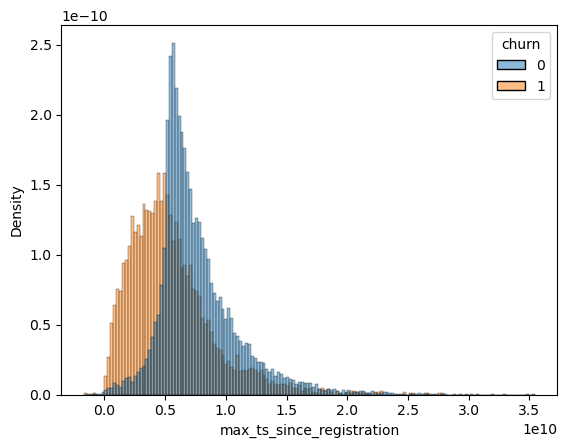

In [63]:
sns.histplot(df_model_tmp, x='max_ts_since_registration', hue='churn', common_norm=False, stat='density')

In [64]:
clf, feats = do_fit(df_model_tmp) # this for dropping registration, min_ts, max_ts

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.740) roc_auc: (test=0.934) total time=   7.2s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.743) roc_auc: (test=0.922) total time=   7.1s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.747) roc_auc: (test=0.941) total time=   7.2s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.731) roc_auc: (test=0.927) total time=   7.1s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.757) roc_auc: (test=0.935) total time=   6.9s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.760) roc_auc: (test=0.922) total time=   7.0s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.773) roc_auc: (test=0.947) total time=   6.9s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.736) roc_auc: (test=0.926) total time=   6.9s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.782) roc_auc: (test=0.936) total time=   6.5s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.764) roc_auc: (test=0.926) total time=   6.5s
[CV 3/4] END min_samples_leaf=

#### seems very hard to pin it to ts-registration, which is somewhat strange

In [60]:
#clf, feats = do_fit(df_model_tmp) # this is for dropping only the registration

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.813) roc_auc: (test=0.948) total time=   7.0s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.821) roc_auc: (test=0.941) total time=   7.1s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.822) roc_auc: (test=0.961) total time=   7.1s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.826) roc_auc: (test=0.951) total time=   6.8s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.827) roc_auc: (test=0.948) total time=   6.7s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.827) roc_auc: (test=0.944) total time=   6.7s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.834) roc_auc: (test=0.959) total time=   6.7s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.829) roc_auc: (test=0.949) total time=   6.7s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.836) roc_auc: (test=0.948) total time=   6.3s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.836) roc_auc: (test=0.943) total time=   6.3s
[CV 3/4] END min_samples_leaf=

#### so this part suggest dropping registration is fine; but max_ts, min_ts is really important

### 3. selecting features useful?

In [65]:
from scipy import stats
def ttest(dat1, dat2, min_count=10):
    if len(dat1) < min_count or len(dat2) < min_count:
        return np.nan
    else:
        return stats.ttest_ind(dat1, dat2)[1]

In [66]:
cols = list(df_model.dtypes.index[df_model.dtypes != 'object'])
cols.remove('churn')
cols

['userId',
 'registration',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'max_ts',
 'min_ts',
 'count',
 'status_307_count',
 'get_count',
 'total_time',
 'avg_gap_time',
 'Submit Downgrade_recent',
 'Thumbs Down_recent',
 'Home_recent',
 'Downgrade_recent',
 'Roll Advert_recent',
 'Logout_recent',
 'Save Settings_recent',
 'About_recent',
 'Settings_recent',
 'Add to Playlist_recent',
 'Add Friend_recent',
 'Thumbs Up_recent',
 'Help_recent',
 'Upgrade_recent',
 'Error_recent',
 'Submit Upgrade_recent',
 'count_recent',
 'status_307_count_recent',
 'get_count_recent',
 'total_time_recent',
 'avg_gap_time_recent',
 'agent_iphone',
 'agent_linux',
 'agent_mac',
 'agent_windows',
 'gender_M',
 'first_level_paid',
 'last_level_paid']

In [67]:
cols_not_selected = []
outputs = []
for col in cols:
    p = ttest(df_model.loc[df_model.churn==0, col].values,
              df_model.loc[df_model.churn==1, col].values)
    outputs.append(p)
    if p > 0.05:
        cols_not_selected.append(col)
outputs = pd.DataFrame.from_dict({'col':cols, 'p':outputs})

In [68]:
outputs.sort_values(by='p')

,col,p
18,max_ts,0.000000e+00
23,total_time,0.000000e+00
24,avg_gap_time,3.594331e-308
44,total_time_recent,3.912184e-236
45,avg_gap_time_recent,2.112399e-184
19,min_ts,1.199632e-183
28,Downgrade_recent,6.249945e-160
5,Downgrade,1.487127e-124
13,Thumbs Up,1.430438e-76
3,Thumbs Down,8.402840e-66


In [69]:
df_model_selected = df_model.drop(columns=cols_not_selected)
df_model_selected.head()

,churn,location,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Settings,Add to Playlist,...,Thumbs Up_recent,Upgrade_recent,Submit Upgrade_recent,count_recent,status_307_count_recent,get_count_recent,total_time_recent,avg_gap_time_recent,first_level_paid,last_level_paid
0,1,"Oxnard-Thousand Oaks-Ventura, CA",0.000399,0.008112,0.035372,0.011037,0.011037,0.011436,0.005319,0.023138,...,0.036298,0.0,0.0,1653,0.071990,0.076830,218.820833,11.482753,0,1
1,0,"New York-Newark-Jersey City, NY-NJ-PA",0.000000,0.006814,0.028109,0.009370,0.002129,0.009370,0.002555,0.020869,...,0.038986,0.0,0.0,513,0.066277,0.038986,235.403056,51.081319,1,1
2,0,"Birmingham-Hoover, AL",0.000000,0.008943,0.032088,0.005260,0.020516,0.012099,0.006312,0.031036,...,0.047002,0.0,0.0,617,0.076175,0.047002,280.317500,80.715741,0,1
3,0,"Miami-Fort Lauderdale-West Palm Beach, FL",0.000678,0.006784,0.044776,0.000678,0.041384,0.018318,0.006784,0.026459,...,0.031447,0.0,0.0,159,0.088050,0.113208,153.583056,48.526852,0,0
4,0,"Edwards, CO",0.000000,0.011004,0.031637,0.009629,0.001376,0.013755,0.006878,0.023384,...,0.047753,0.0,0.0,356,0.084270,0.061798,208.947778,94.525000,1,1


In [70]:
clf, feats = do_fit(df_model_selected)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.819) roc_auc: (test=0.951) total time=   6.4s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.827) roc_auc: (test=0.947) total time=   6.5s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.835) roc_auc: (test=0.961) total time=   6.3s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.821) roc_auc: (test=0.953) total time=   6.3s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.835) roc_auc: (test=0.952) total time=   6.1s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.839) roc_auc: (test=0.946) total time=   6.2s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.841) roc_auc: (test=0.963) total time=   6.2s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.833) roc_auc: (test=0.952) total time=   6.2s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.840) roc_auc: (test=0.950) total time=   5.8s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.837) roc_auc: (test=0.944) total time=   5.9s
[CV 3/4] END min_samples_leaf=

#### roughly the same, suggesting we can remove useless features this way if we want to save some time; it won't affect the final fit though

### 3. some manipulation on change

In [72]:
df_model.columns

Index(['userId', 'churn', 'location', 'registration', 'Submit Downgrade',
       'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout',
       'Save Settings', 'About', 'Settings', 'Add to Playlist', 'Add Friend',
       'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade', 'max_ts',
       'min_ts', 'count', 'status_307_count', 'get_count', 'total_time',
       'avg_gap_time', 'Submit Downgrade_recent', 'Thumbs Down_recent',
       'Home_recent', 'Downgrade_recent', 'Roll Advert_recent',
       'Logout_recent', 'Save Settings_recent', 'About_recent',
       'Settings_recent', 'Add to Playlist_recent', 'Add Friend_recent',
       'Thumbs Up_recent', 'Help_recent', 'Upgrade_recent', 'Error_recent',
       'Submit Upgrade_recent', 'count_recent', 'status_307_count_recent',
       'get_count_recent', 'total_time_recent', 'avg_gap_time_recent',
       'agent_iphone', 'agent_linux', 'agent_mac', 'agent_windows', 'gender_M',
       'first_level_paid', 'last_level_paid'],
      dty

In [73]:
cols = [x for x in df_model.columns if f"{x}_recent" in df_model.columns]
cols

['Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'count',
 'status_307_count',
 'get_count',
 'total_time',
 'avg_gap_time']

In [74]:
df_model_change = df_model.copy()

In [75]:
for col in cols:
    df_model_change[f"{col}_recent"] = df_model_change[f"{col}_recent"] - df_model_change[col]

In [76]:
def stack_and_ready_for_plot(df):
    num_cols = list(df.dtypes.index[df.dtypes != 'object'])
    df = df[num_cols]
    tmp = df.drop(columns=['churn']).stack().reset_index()
    tmp.columns = ['userId','parameter','val']
    tmp = tmp.join(df[['churn']], on='userId')
    return tmp

(-0.2, 0.2)

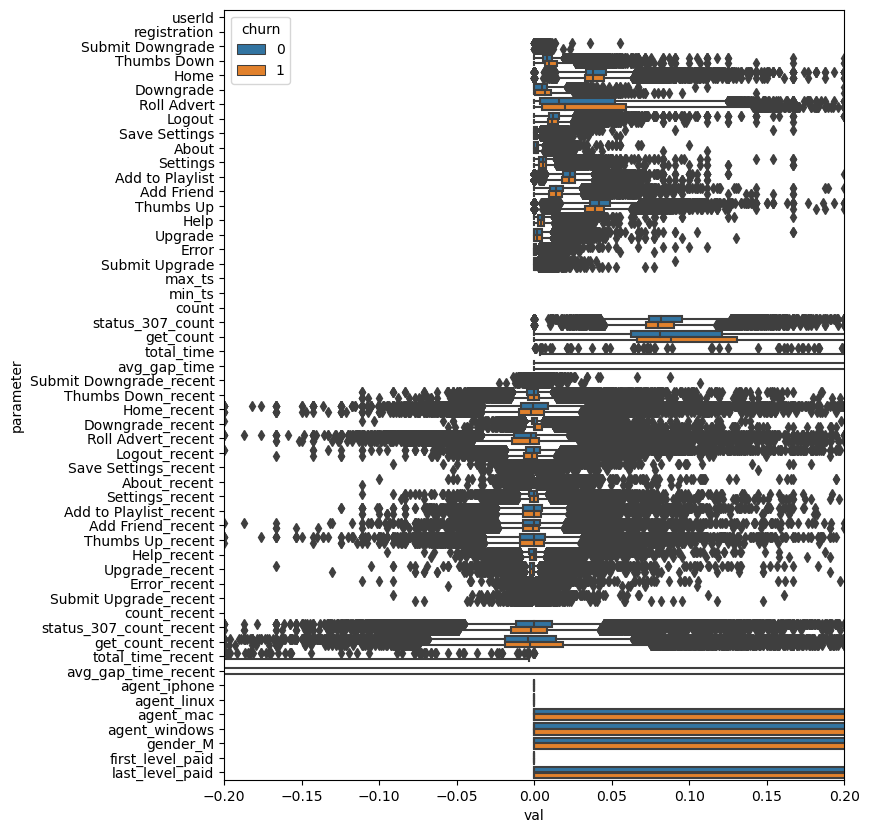

In [77]:
plt.figure(figsize=(8,10))
tmp = stack_and_ready_for_plot(df_model_change)
sns.boxplot(tmp, x='val', y='parameter', hue='churn')
plt.xlim([-0.2,0.2])

In [78]:
clf, feats = do_fit(df_model_change)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.806) roc_auc: (test=0.946) total time=   8.0s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.826) roc_auc: (test=0.938) total time=   8.0s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.816) roc_auc: (test=0.957) total time=   8.1s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.816) roc_auc: (test=0.952) total time=   8.1s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.828) roc_auc: (test=0.947) total time=   7.8s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.830) roc_auc: (test=0.936) total time=   7.8s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.825) roc_auc: (test=0.958) total time=   7.9s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.832) roc_auc: (test=0.950) total time=   7.9s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.832) roc_auc: (test=0.946) total time=   7.4s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.837) roc_auc: (test=0.937) total time=   7.3s
[CV 3/4] END min_samples_leaf=

#### this is very slightly worse

In [79]:
df_model_change = df_model.copy()

In [80]:
for col in cols:
    df_model_change[f"{col}_recent_diff"] = df_model_change[f"{col}_recent"] - df_model_change[col]

In [81]:
clf, feats = do_fit(df_model_change)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.816) roc_auc: (test=0.948) total time=   8.5s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.828) roc_auc: (test=0.941) total time=   8.4s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.820) roc_auc: (test=0.960) total time=   8.5s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.811) roc_auc: (test=0.949) total time=   8.5s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.824) roc_auc: (test=0.947) total time=   8.3s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.834) roc_auc: (test=0.940) total time=   8.3s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.828) roc_auc: (test=0.959) total time=   8.3s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.832) roc_auc: (test=0.949) total time=   8.3s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.845) roc_auc: (test=0.951) total time=   7.7s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.838) roc_auc: (test=0.943) total time=   7.9s
[CV 3/4] END min_samples_leaf=

#### don't see improvement

In [82]:
def select_cols(df):
    cols = list(df.dtypes.index[df.dtypes != 'object'])
    cols.remove('churn')
    cols_not_selected = []
    outputs = []
    for col in cols:
        p = ttest(df.loc[df.churn==0, col].values,
                  df.loc[df.churn==1, col].values)
        outputs.append(p)
        if p > 0.05:
            cols_not_selected.append(col)
    outputs = pd.DataFrame.from_dict({'col':cols, 'p':outputs})
    df_selected = df.drop(columns=cols_not_selected)
    return df_selected, outputs

In [83]:
df_model_change_selected, outputs = select_cols(df_model_change)

In [84]:
outputs.sort_values(by='p')

,col,p
72,total_time_recent_diff,0.000000e+00
23,total_time,0.000000e+00
18,max_ts,0.000000e+00
24,avg_gap_time,3.594331e-308
44,total_time_recent,3.912184e-236
...,...,...
68,Submit Upgrade_recent_diff,4.935983e-01
15,Upgrade,5.918451e-01
0,userId,6.280260e-01
25,Submit Downgrade_recent,7.049676e-01


In [85]:
df_model_change.shape, df_model_change_selected.shape

((22261, 76), (22261, 58))

In [86]:
clf, feats = do_fit(df_model_change_selected)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.809) roc_auc: (test=0.948) total time=   9.0s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.832) roc_auc: (test=0.944) total time=   9.6s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.815) roc_auc: (test=0.960) total time=   9.0s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.821) roc_auc: (test=0.950) total time=   8.6s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.834) roc_auc: (test=0.951) total time=   8.3s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.835) roc_auc: (test=0.942) total time=   8.0s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.833) roc_auc: (test=0.957) total time=   8.5s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.829) roc_auc: (test=0.950) total time=   8.1s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.843) roc_auc: (test=0.951) total time=   7.6s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.838) roc_auc: (test=0.942) total time=   7.5s
[CV 3/4] END min_samples_leaf=

#### simply selecting features won't do any improvement

In [87]:
cols

['Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade',
 'count',
 'status_307_count',
 'get_count',
 'total_time',
 'avg_gap_time']

In [88]:
for col in cols:
    df_model_change[f"{col}_recent_diff_ratio"] = df_model_change[f"{col}_recent_diff"] / (df_model_change[col] + 1e-6)

In [89]:
df_model_change.describe()

,userId,churn,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Save Settings,...,Thumbs Up_recent_diff_ratio,Help_recent_diff_ratio,Upgrade_recent_diff_ratio,Error_recent_diff_ratio,Submit Upgrade_recent_diff_ratio,count_recent_diff_ratio,status_307_count_recent_diff_ratio,get_count_recent_diff_ratio,total_time_recent_diff_ratio,avg_gap_time_recent_diff_ratio
count,2.226100e+04,22261.000000,2.226100e+04,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,...,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000,22261.000000
mean,1.498828e+06,0.224743,1.535282e+12,0.000255,0.010198,0.042074,0.005739,0.031194,0.014069,0.001259,...,-0.014089,0.016809,-0.217063,-0.017827,-0.246388,-0.702572,0.016897,0.095175,-0.888522,-0.427322
std,2.888999e+05,0.417422,3.246735e+09,0.000876,0.009361,0.022277,0.006749,0.035908,0.014284,0.002889,...,0.593624,1.580704,1.464276,1.262316,1.081571,0.201342,0.513728,0.957523,0.075131,0.537880
min,1.000025e+06,0.000000,1.508019e+12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.999996,-0.999990,-0.999994,-0.999991,-0.999989,-0.999431,-0.999997,-0.999998,-1.000000,-1.000000
25%,1.243856e+06,0.000000,1.534052e+12,0.000000,0.006036,0.033058,0.000000,0.003645,0.009204,0.000000,...,-0.213036,-0.999553,-0.999560,-0.998445,-0.998648,-0.848921,-0.147725,-0.223687,-0.977183,-1.000000
50%,1.499807e+06,0.000000,1.536222e+12,0.000000,0.008462,0.037940,0.005364,0.016760,0.011921,0.000638,...,-0.002863,0.000000,-0.494509,0.000000,0.000000,-0.749920,-0.007485,-0.048153,-0.863825,-0.467372
75%,1.747217e+06,0.000000,1.537493e+12,0.000000,0.011706,0.045794,0.008876,0.052980,0.015905,0.001645,...,0.163632,0.248535,0.000000,0.000000,0.000000,-0.596068,0.125580,0.167980,-0.818333,-0.072739
max,1.999996e+06,1.000000,1.543822e+12,0.055556,0.333333,0.500000,0.250000,0.500000,0.500000,0.166667,...,12.373676,77.493917,60.285218,40.042001,50.043694,-0.004348,13.332760,25.332333,-0.800000,4.801585


In [90]:
clf, feats = do_fit(df_model_change)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.802) roc_auc: (test=0.948) total time=  10.2s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.816) roc_auc: (test=0.941) total time=  11.3s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.813) roc_auc: (test=0.961) total time=  10.6s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.817) roc_auc: (test=0.946) total time=  10.2s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.821) roc_auc: (test=0.949) total time=   9.8s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.822) roc_auc: (test=0.941) total time=  10.0s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.826) roc_auc: (test=0.960) total time=   9.7s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.820) roc_auc: (test=0.952) total time=   9.9s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.837) roc_auc: (test=0.947) total time=   9.2s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.837) roc_auc: (test=0.942) total time=   9.3s
[CV 3/4] END min_samples_leaf=

#### this is not that much different either!

In [93]:
cols = [col for col in df_model.columns if '_recent' in col]
cols

['Submit Downgrade_recent',
 'Thumbs Down_recent',
 'Home_recent',
 'Downgrade_recent',
 'Roll Advert_recent',
 'Logout_recent',
 'Save Settings_recent',
 'About_recent',
 'Settings_recent',
 'Add to Playlist_recent',
 'Add Friend_recent',
 'Thumbs Up_recent',
 'Help_recent',
 'Upgrade_recent',
 'Error_recent',
 'Submit Upgrade_recent',
 'count_recent',
 'status_307_count_recent',
 'get_count_recent',
 'total_time_recent',
 'avg_gap_time_recent']

In [94]:
df_model_no_recent = df_model.copy().drop(columns=cols)

In [95]:
df_model_no_recent.shape

(22261, 34)

In [96]:
clf, feats = do_fit(df_model_no_recent)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.819) roc_auc: (test=0.938) total time=   5.2s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.810) roc_auc: (test=0.936) total time=   5.1s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.813) roc_auc: (test=0.958) total time=   5.5s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.813) roc_auc: (test=0.947) total time=   5.5s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.829) roc_auc: (test=0.935) total time=   5.3s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.820) roc_auc: (test=0.936) total time=   5.3s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.821) roc_auc: (test=0.955) total time=   5.3s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.833) roc_auc: (test=0.949) total time=   5.3s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.836) roc_auc: (test=0.945) total time=   5.0s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.836) roc_auc: (test=0.939) total time=   4.9s
[CV 3/4] END min_samples_leaf=

#### removing recent does hurt

#### so there might be slightly improvement by adding recent - all; selecting features is not that useful

### 4. do something about state?

In [97]:
df_model['state'] = df_model['location'].apply(lambda x: x.split(',')[1].split('-')[0])

In [98]:
df_model.churn.mean()

0.22474282377251695

In [99]:
df_model.groupby('state').agg({'userId':'count','churn':'mean'}).sort_values(by='churn')

,userId,churn
state,,
MT,48,0.125000
ND,43,0.139535
NJ,61,0.163934
IA,192,0.182292
KS,120,0.183333
KY,226,0.185841
MN,358,0.201117
CO,359,0.203343
WA,504,0.210317


In [100]:
df_model_states = pd.get_dummies(df_model, columns=['state'], drop_first=True, dtype=int)
df_model_states

,userId,churn,location,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,...,state_ SD,state_ TN,state_ TX,state_ UT,state_ VA,state_ VT,state_ WA,state_ WI,state_ WV,state_ WY
0,1662639,1,"Oxnard-Thousand Oaks-Ventura, CA",1534024341000,0.000399,0.008112,0.035372,0.011037,0.011037,0.011436,...,0,0,0,0,0,0,0,0,0,0
1,1090823,0,"New York-Newark-Jersey City, NY-NJ-PA",1537927525000,0.000000,0.006814,0.028109,0.009370,0.002129,0.009370,...,0,0,0,0,0,0,0,0,0,0
2,1321163,0,"Birmingham-Hoover, AL",1537817518000,0.000000,0.008943,0.032088,0.005260,0.020516,0.012099,...,0,0,0,0,0,0,0,0,0,0
3,1839943,0,"Miami-Fort Lauderdale-West Palm Beach, FL",1535904852000,0.000678,0.006784,0.044776,0.000678,0.041384,0.018318,...,0,0,0,0,0,0,0,0,0,0
4,1331962,0,"Edwards, CO",1536901904000,0.000000,0.011004,0.031637,0.009629,0.001376,0.013755,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22256,1679128,0,"San Diego-Carlsbad, CA",1535979645000,0.000000,0.000000,0.044118,0.000000,0.000000,0.014706,...,0,0,0,0,0,0,0,0,0,0
22257,1105395,0,"Minneapolis-St. Paul-Bloomington, MN-WI",1529776594000,0.000000,0.015385,0.061538,0.000000,0.000000,0.046154,...,0,0,0,0,0,0,0,0,0,0
22258,1913790,0,"Chicago-Naperville-Elgin, IL-IN-WI",1533361992000,0.000000,0.000000,0.039683,0.000000,0.000000,0.007937,...,0,0,0,0,0,0,0,0,0,0
22259,1480584,0,"Los Angeles-Long Beach-Anaheim, CA",1537029126000,0.010000,0.040000,0.030000,0.020000,0.060000,0.020000,...,0,0,0,0,0,0,0,0,0,0


In [101]:
clf, feats = do_fit(df_model_states)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.810) roc_auc: (test=0.948) total time=   5.4s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.816) roc_auc: (test=0.946) total time=   5.4s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.826) roc_auc: (test=0.963) total time=   5.5s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.824) roc_auc: (test=0.951) total time=   5.4s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.832) roc_auc: (test=0.950) total time=   5.3s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.831) roc_auc: (test=0.942) total time=   5.4s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.837) roc_auc: (test=0.959) total time=   5.5s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.826) roc_auc: (test=0.949) total time=   5.4s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.849) roc_auc: (test=0.950) total time=   5.1s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.838) roc_auc: (test=0.941) total time=   5.1s
[CV 3/4] END min_samples_leaf=

#### this improves very slightly

In [102]:
tmp = df_model.groupby('state').agg({'userId':'count','churn':'mean'}).sort_values(by='churn')
tmp

,userId,churn
state,,
MT,48,0.125000
ND,43,0.139535
NJ,61,0.163934
IA,192,0.182292
KS,120,0.183333
KY,226,0.185841
MN,358,0.201117
CO,359,0.203343
WA,504,0.210317


In [103]:
state_map = pd.qcut(tmp.churn, q=5, labels=['state_0','state_1','state_2','state_3','state_4'])
df_model['state_qcat'] = df_model.state.map(state_map)
df_model

,userId,churn,location,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,...,avg_gap_time_recent,agent_iphone,agent_linux,agent_mac,agent_windows,gender_M,first_level_paid,last_level_paid,state,state_qcat
0,1662639,1,"Oxnard-Thousand Oaks-Ventura, CA",1534024341000,0.000399,0.008112,0.035372,0.011037,0.011037,0.011436,...,11.482753,0,0,0,1,1,0,1,CA,state_1
1,1090823,0,"New York-Newark-Jersey City, NY-NJ-PA",1537927525000,0.000000,0.006814,0.028109,0.009370,0.002129,0.009370,...,51.081319,0,0,0,1,1,1,1,NY,state_1
2,1321163,0,"Birmingham-Hoover, AL",1537817518000,0.000000,0.008943,0.032088,0.005260,0.020516,0.012099,...,80.715741,0,0,0,1,1,0,1,AL,state_1
3,1839943,0,"Miami-Fort Lauderdale-West Palm Beach, FL",1535904852000,0.000678,0.006784,0.044776,0.000678,0.041384,0.018318,...,48.526852,0,0,1,0,0,0,0,FL,state_1
4,1331962,0,"Edwards, CO",1536901904000,0.000000,0.011004,0.031637,0.009629,0.001376,0.013755,...,94.525000,0,0,0,1,1,1,1,CO,state_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22256,1679128,0,"San Diego-Carlsbad, CA",1535979645000,0.000000,0.000000,0.044118,0.000000,0.000000,0.014706,...,0.000000,0,0,1,0,0,1,1,CA,state_1
22257,1105395,0,"Minneapolis-St. Paul-Bloomington, MN-WI",1529776594000,0.000000,0.015385,0.061538,0.000000,0.000000,0.046154,...,0.000000,0,0,0,1,0,1,1,MN,state_0
22258,1913790,0,"Chicago-Naperville-Elgin, IL-IN-WI",1533361992000,0.000000,0.000000,0.039683,0.000000,0.000000,0.007937,...,0.000000,0,0,1,0,0,0,1,IL,state_0
22259,1480584,0,"Los Angeles-Long Beach-Anaheim, CA",1537029126000,0.010000,0.040000,0.030000,0.020000,0.060000,0.020000,...,0.000000,0,0,1,0,1,1,0,CA,state_1


In [104]:
df_model_states = pd.get_dummies(df_model.drop(columns=['state']), columns=['state_qcat'], drop_first=True, dtype=int)

In [105]:
df_model_states

,userId,churn,location,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,...,agent_linux,agent_mac,agent_windows,gender_M,first_level_paid,last_level_paid,state_qcat_state_1,state_qcat_state_2,state_qcat_state_3,state_qcat_state_4
0,1662639,1,"Oxnard-Thousand Oaks-Ventura, CA",1534024341000,0.000399,0.008112,0.035372,0.011037,0.011037,0.011436,...,0,0,1,1,0,1,1,0,0,0
1,1090823,0,"New York-Newark-Jersey City, NY-NJ-PA",1537927525000,0.000000,0.006814,0.028109,0.009370,0.002129,0.009370,...,0,0,1,1,1,1,1,0,0,0
2,1321163,0,"Birmingham-Hoover, AL",1537817518000,0.000000,0.008943,0.032088,0.005260,0.020516,0.012099,...,0,0,1,1,0,1,1,0,0,0
3,1839943,0,"Miami-Fort Lauderdale-West Palm Beach, FL",1535904852000,0.000678,0.006784,0.044776,0.000678,0.041384,0.018318,...,0,1,0,0,0,0,1,0,0,0
4,1331962,0,"Edwards, CO",1536901904000,0.000000,0.011004,0.031637,0.009629,0.001376,0.013755,...,0,0,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22256,1679128,0,"San Diego-Carlsbad, CA",1535979645000,0.000000,0.000000,0.044118,0.000000,0.000000,0.014706,...,0,1,0,0,1,1,1,0,0,0
22257,1105395,0,"Minneapolis-St. Paul-Bloomington, MN-WI",1529776594000,0.000000,0.015385,0.061538,0.000000,0.000000,0.046154,...,0,0,1,0,1,1,0,0,0,0
22258,1913790,0,"Chicago-Naperville-Elgin, IL-IN-WI",1533361992000,0.000000,0.000000,0.039683,0.000000,0.000000,0.007937,...,0,1,0,0,0,1,0,0,0,0
22259,1480584,0,"Los Angeles-Long Beach-Anaheim, CA",1537029126000,0.010000,0.040000,0.030000,0.020000,0.060000,0.020000,...,0,1,0,1,1,0,1,0,0,0


In [106]:
clf, feats = do_fit(df_model_states)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END min_samples_leaf=1; f1: (test=0.815) roc_auc: (test=0.946) total time=   6.4s
[CV 2/4] END min_samples_leaf=1; f1: (test=0.823) roc_auc: (test=0.938) total time=   6.3s
[CV 3/4] END min_samples_leaf=1; f1: (test=0.827) roc_auc: (test=0.961) total time=   6.3s
[CV 4/4] END min_samples_leaf=1; f1: (test=0.814) roc_auc: (test=0.950) total time=   6.5s
[CV 1/4] END min_samples_leaf=2; f1: (test=0.827) roc_auc: (test=0.947) total time=   6.4s
[CV 2/4] END min_samples_leaf=2; f1: (test=0.825) roc_auc: (test=0.943) total time=   6.4s
[CV 3/4] END min_samples_leaf=2; f1: (test=0.842) roc_auc: (test=0.963) total time=   6.3s
[CV 4/4] END min_samples_leaf=2; f1: (test=0.832) roc_auc: (test=0.953) total time=   6.4s
[CV 1/4] END min_samples_leaf=5; f1: (test=0.849) roc_auc: (test=0.953) total time=   5.9s
[CV 2/4] END min_samples_leaf=5; f1: (test=0.838) roc_auc: (test=0.941) total time=   6.1s
[CV 3/4] END min_samples_leaf=

#### adding state improves very slightly, better to use all states

### 5. try different models?

In [107]:
df_model = df_model.drop(columns=['state','state_qcat'])

In [109]:
from sklearn.preprocessing import PowerTransformer

In [110]:
def do_fit_logistic(df):
    X, y = df.drop(columns=['churn', 'location']).values, df.churn.values
    feats = df.drop(columns=['churn', 'location']).columns
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    pipeline = Pipeline([
        ('preprocess', PowerTransformer()),
        ('clf', LogisticRegression(class_weight='balanced'))
    ])
    
    clf = GridSearchCV(pipeline,
                       param_grid = {'clf__C':[0.01,0.03,0.05,0.07,0.1,0.15,0.2,0.5]},
                       cv = 4,
                       scoring = ['f1', 'roc_auc'],
                       refit = 'f1',
                       verbose = 3)
    
    clf.fit(X_train, y_train)
    
    print('best param:', clf.best_params_)
    print('f1 score on test:', f1_score(clf.predict(X_test), y_test))
    
    return clf, feats

In [114]:
# needs this, otherwise it overflows
df_model_tmp = df_model.copy()
ref_ts = df_model_tmp.registration.min()
for col in ['registration','max_ts','min_ts']:
    df_model_tmp[col] = (df_model_tmp[col] - ref_ts)/3600/1000
clf, feats = do_fit_logistic(df_model_tmp)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV 1/4] END clf__C=0.01; f1: (test=0.792) roc_auc: (test=0.953) total time=   0.7s
[CV 2/4] END clf__C=0.01; f1: (test=0.793) roc_auc: (test=0.955) total time=   0.7s
[CV 3/4] END clf__C=0.01; f1: (test=0.786) roc_auc: (test=0.945) total time=   0.7s
[CV 4/4] END clf__C=0.01; f1: (test=0.769) roc_auc: (test=0.941) total time=   0.8s
[CV 1/4] END clf__C=0.03; f1: (test=0.792) roc_auc: (test=0.955) total time=   0.8s
[CV 2/4] END clf__C=0.03; f1: (test=0.794) roc_auc: (test=0.956) total time=   0.8s
[CV 3/4] END clf__C=0.03; f1: (test=0.790) roc_auc: (test=0.946) total time=   0.8s
[CV 4/4] END clf__C=0.03; f1: (test=0.772) roc_auc: (test=0.942) total time=   0.8s
[CV 1/4] END clf__C=0.05; f1: (test=0.792) roc_auc: (test=0.955) total time=   0.8s
[CV 2/4] END clf__C=0.05; f1: (test=0.791) roc_auc: (test=0.956) total time=   0.8s
[CV 3/4] END clf__C=0.05; f1: (test=0.792) roc_auc: (test=0.946) total time=   0.7s
[CV 4/4] END clf

In [115]:
def importance_plot(importance, cols, figsize=(10,20)):
    tmp = pd.DataFrame(importance.reshape(-1,1), index=cols)
    tmp.reset_index(inplace=True)
    tmp.columns = ('feature','importance')
    plt.figure(figsize = figsize)
    sns.barplot(data = tmp,
                x = 'importance',
                y = 'feature',
                order = tmp.sort_values(by='importance').feature)

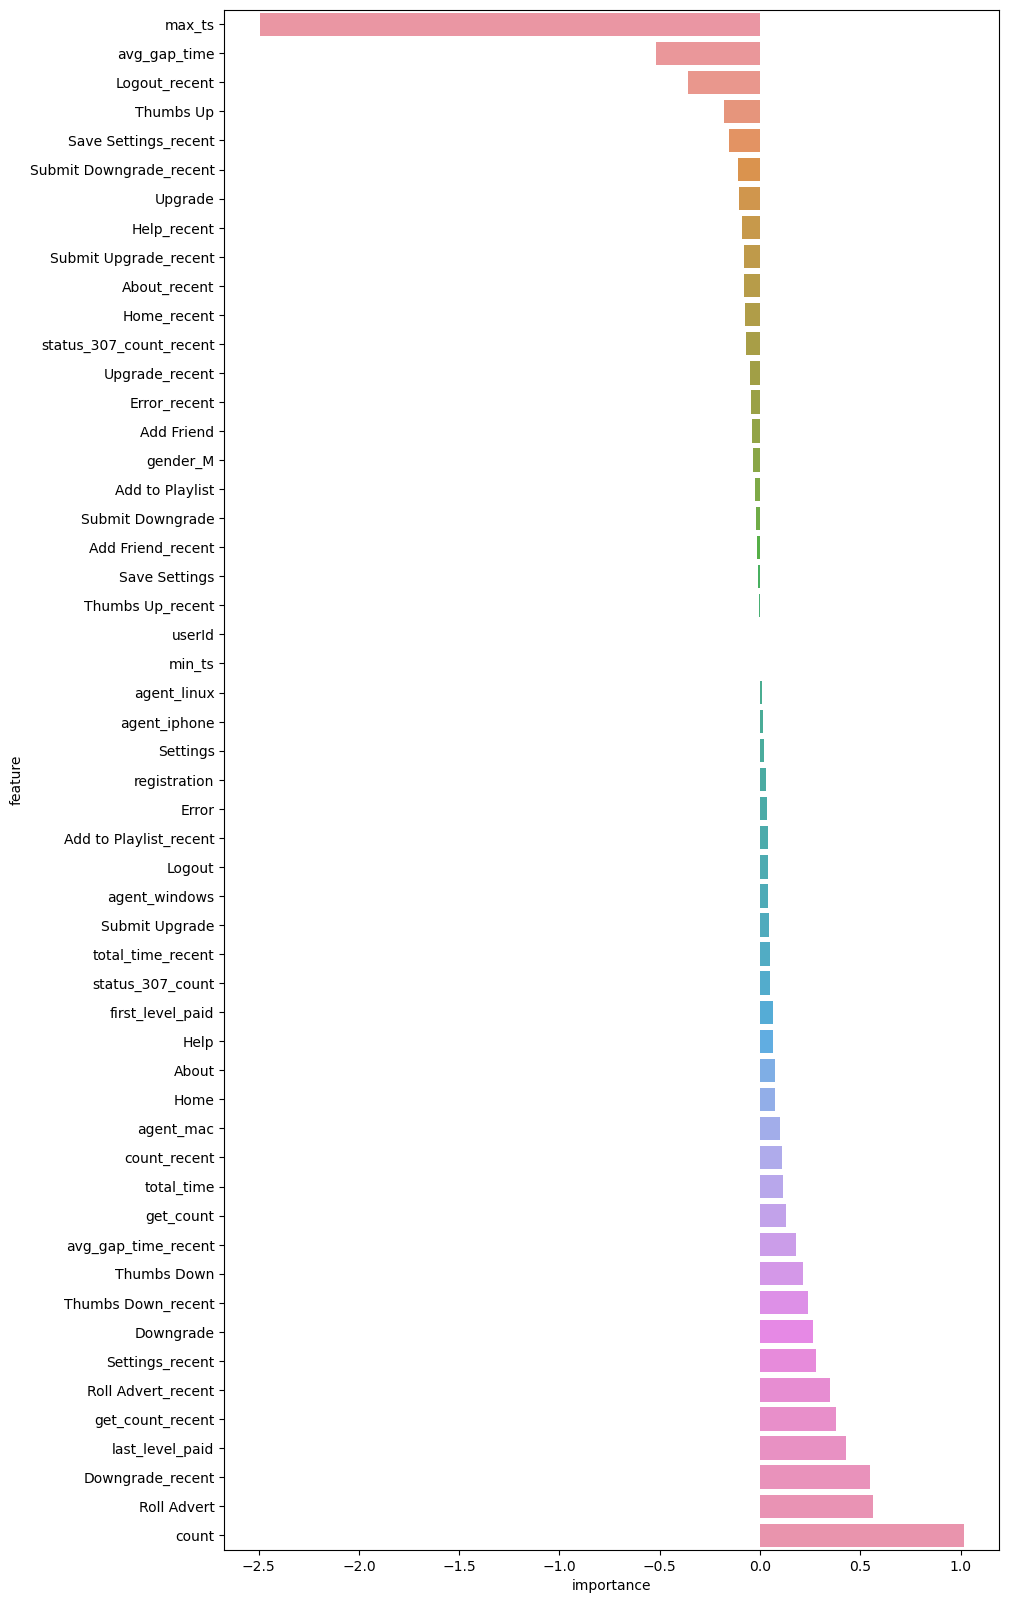

In [116]:
importance_plot(clf.best_estimator_[1].coef_, feats)

In [117]:
def do_fit_svc(df):
    X, y = df.drop(columns=['churn', 'location']).values, df.churn.values
    feats = df.drop(columns=['churn', 'location']).columns
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    pipeline = Pipeline([
        ('preprocess', PowerTransformer()),
        ('clf', SVC(class_weight='balanced'))
    ])
    
    clf = GridSearchCV(pipeline,
                       param_grid = {'clf__C':[0.1,0.5,1.0,5.0,10.0],
                                     'clf__kernel':['poly','rbf','linear']},
                       cv = 4,
                       scoring = ['f1', 'roc_auc'],
                       refit = 'f1',
                       verbose = 3)
    
    clf.fit(X_train, y_train)
    
    print('best param:', clf.best_params_)
    print('f1 score on test:', f1_score(clf.predict(X_test), y_test))
    
    return clf, feats

In [118]:
clf, feats = do_fit_svc(df_model_tmp)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
[CV 1/4] END clf__C=0.1, clf__kernel=poly; f1: (test=0.797) roc_auc: (test=0.942) total time=  11.3s
[CV 2/4] END clf__C=0.1, clf__kernel=poly; f1: (test=0.793) roc_auc: (test=0.939) total time=  10.9s
[CV 3/4] END clf__C=0.1, clf__kernel=poly; f1: (test=0.770) roc_auc: (test=0.929) total time=  11.1s
[CV 4/4] END clf__C=0.1, clf__kernel=poly; f1: (test=0.752) roc_auc: (test=0.926) total time=  11.0s
[CV 1/4] END clf__C=0.1, clf__kernel=rbf; f1: (test=0.794) roc_auc: (test=0.948) total time=  16.8s
[CV 2/4] END clf__C=0.1, clf__kernel=rbf; f1: (test=0.791) roc_auc: (test=0.950) total time=  16.9s
[CV 3/4] END clf__C=0.1, clf__kernel=rbf; f1: (test=0.790) roc_auc: (test=0.941) total time=  16.2s
[CV 4/4] END clf__C=0.1, clf__kernel=rbf; f1: (test=0.774) roc_auc: (test=0.939) total time=  15.3s
[CV 1/4] END clf__C=0.1, clf__kernel=linear; f1: (test=0.803) roc_auc: (test=0.955) total time=   6.1s
[CV 2/4] END clf__C=0.1, clf__ke

In [119]:
df_model

,userId,churn,location,registration,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,...,get_count_recent,total_time_recent,avg_gap_time_recent,agent_iphone,agent_linux,agent_mac,agent_windows,gender_M,first_level_paid,last_level_paid
0,1662639,1,"Oxnard-Thousand Oaks-Ventura, CA",1534024341000,0.000399,0.008112,0.035372,0.011037,0.011037,0.011436,...,0.076830,218.820833,11.482753,0,0,0,1,1,0,1
1,1090823,0,"New York-Newark-Jersey City, NY-NJ-PA",1537927525000,0.000000,0.006814,0.028109,0.009370,0.002129,0.009370,...,0.038986,235.403056,51.081319,0,0,0,1,1,1,1
2,1321163,0,"Birmingham-Hoover, AL",1537817518000,0.000000,0.008943,0.032088,0.005260,0.020516,0.012099,...,0.047002,280.317500,80.715741,0,0,0,1,1,0,1
3,1839943,0,"Miami-Fort Lauderdale-West Palm Beach, FL",1535904852000,0.000678,0.006784,0.044776,0.000678,0.041384,0.018318,...,0.113208,153.583056,48.526852,0,0,1,0,0,0,0
4,1331962,0,"Edwards, CO",1536901904000,0.000000,0.011004,0.031637,0.009629,0.001376,0.013755,...,0.061798,208.947778,94.525000,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22256,1679128,0,"San Diego-Carlsbad, CA",1535979645000,0.000000,0.000000,0.044118,0.000000,0.000000,0.014706,...,0.181818,0.553056,0.000000,0,0,1,0,0,1,1
22257,1105395,0,"Minneapolis-St. Paul-Bloomington, MN-WI",1529776594000,0.000000,0.015385,0.061538,0.000000,0.000000,0.046154,...,0.083333,0.691111,0.000000,0,0,0,1,0,1,1
22258,1913790,0,"Chicago-Naperville-Elgin, IL-IN-WI",1533361992000,0.000000,0.000000,0.039683,0.000000,0.000000,0.007937,...,0.000000,1.228333,0.000000,0,0,1,0,0,0,1
22259,1480584,0,"Los Angeles-Long Beach-Anaheim, CA",1537029126000,0.010000,0.040000,0.030000,0.020000,0.060000,0.020000,...,0.068966,1.246667,0.000000,0,0,1,0,1,1,0


### 6. use the xgboost

In [120]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from itertools import product
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from copy import deepcopy
from cv_result_analyzer import CVResultAnalyzer

In [141]:
class CV_xgboost(CVResultAnalyzer):
    '''
       helper class to run grid search on xgboost
    '''
    def __init__(self, obj="binary:logistic"):
        self.objective = obj
    
    def fit(self, X, y, param_grid, kf=StratifiedKFold(n_splits=4), verbose=True, target='1'):
        ''' do some cv on param_grid '''
        cols = defaultdict(list)
        
        # loop over each param combination
        param_names, param_vals = list(zip(*param_grid.items()))
        for param_val in product(*param_vals):
            param = dict(zip(param_names, param_val))
            print(f"doing {param}")
            for k, v in param.items():
                cols[k].append(v)
            
            # loop over the splits
            scores = []
            for train_idx, test_idx in kf.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                X_test, y_test = X[test_idx], y[test_idx]
                clf = XGBClassifier(**param, objective=self.objective)
                clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=verbose)
                scores.append(clf.best_score)
            print(scores)
            
            # store the result for this test
            for isplit, score in enumerate(scores):
                cols[f'split_{isplit}'].append(score)
            cols['mean_test'].append(np.mean(scores))
            cols['std_test'].append(np.std(scores))
        
        # turn it into pd
        self.result_df = pd.DataFrame.from_dict(cols)
        self.result_df['target'] = target        
        self.result_df.reset_index(names=['id'], inplace=True) # this is useful in scatterplot
    
    def refit(self, X, y, best_param, kf=StratifiedKFold(n_splits=4), verbose=True):
        ''' 
          keep the clf for each split and when predict, give the average
          useful to fit at a lower learning rate
        '''
        self.clfs = []
        for train_idx, test_idx in kf.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            best_param['n_estimators'] = 10000 # first do an early stop
            clf = XGBClassifier(**best_param, objective=self.objective)
            clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=verbose)
            # refit at the best point
            best_param['n_estimators'] = clf.best_ntree_limit # then do a refit at the best iter
            clf = XGBClassifier(**best_param, objective=self.objective)
            clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=verbose)
            self.clfs.append(deepcopy(clf))
    
    def predict(self, X):
        p = self.predict_proba(X)[:,1]
        y_pred = np.where(p>0.5, 1, 0)
        return y_pred
    
    def predict_proba(self, X):
        for i, clf in enumerate(self.clfs):
            if i == 0:
                p = clf.predict_proba(X)
            else:
                p = p + clf.predict_proba(X)
        p = p / len(self.clfs)
        return p

In [127]:
import numpy as np

def f1_eval_error(y_true, dtrain):
    y_pred = np.where(dtrain>0.5, 1.0, 0.0)
#     return 'f1_eval', f1_score(y_pred, y_true)
    return 1-f1_score(y_pred, y_true)

In [128]:
param_grid = {'gamma': [0], # default
              'max_depth': [2,3,4,6,8],
              'min_child_weight': [1], # default
              'scale_pos_weight': [1,4], # is this useful
              'n_estimators': [10000],
              'early_stopping_rounds': [20],
              'learning_rate': [0.3],
              'eval_metric': [f1_eval_error]}
# param_grid = {'gamma': [0],
#               'max_depth': [4,6],
#               'min_child_weight': [0],
#               'scale_pos_weight': [1, 4, 5],
#               'n_estimators': [10000],
#               'early_stopping_rounds': [20],
#               'learning_rate': [0.3],
#               'eval_metric': [f1_eval_error]}

In [135]:
X, y = df_model_tmp.drop(columns=['churn', 'location']).values, df_model_tmp.churn.values
feats = df_model_tmp.drop(columns=['churn', 'location']).columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

cv_helper = CV_xgboost()
cv_helper.fit(X_train, y_train, param_grid, verbose=10, kf=ShuffleSplit(n_splits=4, random_state=42))

doing {'gamma': 0, 'max_depth': 2, 'min_child_weight': 1, 'scale_pos_weight': 1, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1441670d0>}
[0]	validation_0-logloss:0.53104	validation_0-f1_eval_error:0.29226
[10]	validation_0-logloss:0.24661	validation_0-f1_eval_error:0.22190
[20]	validation_0-logloss:0.21811	validation_0-f1_eval_error:0.19602
[30]	validation_0-logloss:0.20428	validation_0-f1_eval_error:0.18005
[40]	validation_0-logloss:0.19639	validation_0-f1_eval_error:0.17241
[50]	validation_0-logloss:0.19244	validation_0-f1_eval_error:0.17012
[60]	validation_0-logloss:0.18955	validation_0-f1_eval_error:0.16851
[70]	validation_0-logloss:0.18847	validation_0-f1_eval_error:0.16690
[80]	validation_0-logloss:0.18648	validation_0-f1_eval_error:0.16369
[90]	validation_0-logloss:0.18674	validation_0-f1_eval_error:0.16484
[98]	validation_0-logloss:0.18600	validation_0-f1_eval_error:0.16279
[0]	validation_0-logloss:0.5276

[60]	validation_0-logloss:0.18106	validation_0-f1_eval_error:0.15508
[70]	validation_0-logloss:0.18026	validation_0-f1_eval_error:0.15591
[80]	validation_0-logloss:0.18096	validation_0-f1_eval_error:0.16173
[0]	validation_0-logloss:0.51590	validation_0-f1_eval_error:0.22572
[10]	validation_0-logloss:0.22354	validation_0-f1_eval_error:0.18439
[20]	validation_0-logloss:0.20016	validation_0-f1_eval_error:0.16800
[30]	validation_0-logloss:0.19224	validation_0-f1_eval_error:0.15942
[40]	validation_0-logloss:0.18877	validation_0-f1_eval_error:0.16010
[50]	validation_0-logloss:0.18634	validation_0-f1_eval_error:0.15927
[52]	validation_0-logloss:0.18565	validation_0-f1_eval_error:0.16230
[0.161826, 0.159944, 0.152406, 0.156373]
doing {'gamma': 0, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 4, 'n_estimators': 10000, 'early_stopping_rounds': 20, 'learning_rate': 0.3, 'eval_metric': <function f1_eval_error at 0x1441670d0>}
[0]	validation_0-logloss:0.54900	validation_0-f1_eval_error

[71]	validation_0-logloss:0.20176	validation_0-f1_eval_error:0.17566
[0]	validation_0-logloss:0.50206	validation_0-f1_eval_error:0.21866
[10]	validation_0-logloss:0.20459	validation_0-f1_eval_error:0.17847
[20]	validation_0-logloss:0.19543	validation_0-f1_eval_error:0.16084
[30]	validation_0-logloss:0.19955	validation_0-f1_eval_error:0.16597
[39]	validation_0-logloss:0.20519	validation_0-f1_eval_error:0.16343
[0]	validation_0-logloss:0.50227	validation_0-f1_eval_error:0.20988
[10]	validation_0-logloss:0.19585	validation_0-f1_eval_error:0.16463
[20]	validation_0-logloss:0.18698	validation_0-f1_eval_error:0.15200
[30]	validation_0-logloss:0.18637	validation_0-f1_eval_error:0.16267
[40]	validation_0-logloss:0.18788	validation_0-f1_eval_error:0.15579
[0]	validation_0-logloss:0.50332	validation_0-f1_eval_error:0.19430
[10]	validation_0-logloss:0.20501	validation_0-f1_eval_error:0.15556
[20]	validation_0-logloss:0.19409	validation_0-f1_eval_error:0.15637
[30]	validation_0-logloss:0.19278	val

In [136]:
cv_helper.result_df

,id,gamma,max_depth,min_child_weight,scale_pos_weight,n_estimators,early_stopping_rounds,learning_rate,eval_metric,split_0,split_1,split_2,split_3,mean_test,std_test,target
0,0,0,2,1,1,10000,20,0.3,<function f1_eval_error at 0x1441670d0>,0.162534,0.159664,0.158177,0.156785,0.159290,0.002132,1
1,1,0,2,1,4,10000,20,0.3,<function f1_eval_error at 0x1441670d0>,0.171324,0.181598,0.172333,0.184770,0.177506,0.005798,1
2,2,0,3,1,1,10000,20,0.3,<function f1_eval_error at 0x1441670d0>,0.161826,0.159944,0.152406,0.156373,0.157637,0.003600,1
3,3,0,3,1,4,10000,20,0.3,<function f1_eval_error at 0x1441670d0>,0.175460,0.183272,0.166667,0.169550,0.173737,0.006352,1
4,4,0,4,1,1,10000,20,0.3,<function f1_eval_error at 0x1441670d0>,0.165969,0.155989,0.160162,0.148771,0.157723,0.006267,1
5,5,0,4,1,4,10000,20,0.3,<function f1_eval_error at 0x1441670d0>,0.169118,0.180247,0.160523,0.172093,0.170495,0.007053,1
6,6,0,6,1,1,10000,20,0.3,<function f1_eval_error at 0x1441670d0>,0.166667,0.159218,0.152000,0.152632,0.157629,0.005934,1
7,7,0,6,1,4,10000,20,0.3,<function f1_eval_error at 0x1441670d0>,0.160401,0.160000,0.166052,0.156597,0.160763,0.003393,1
8,8,0,8,1,1,10000,20,0.3,<function f1_eval_error at 0x1441670d0>,0.166437,0.151515,0.156208,0.157068,0.157807,0.005412,1
9,9,0,8,1,4,10000,20,0.3,<function f1_eval_error at 0x1441670d0>,0.158730,0.150611,0.150968,0.165829,0.156534,0.006271,1


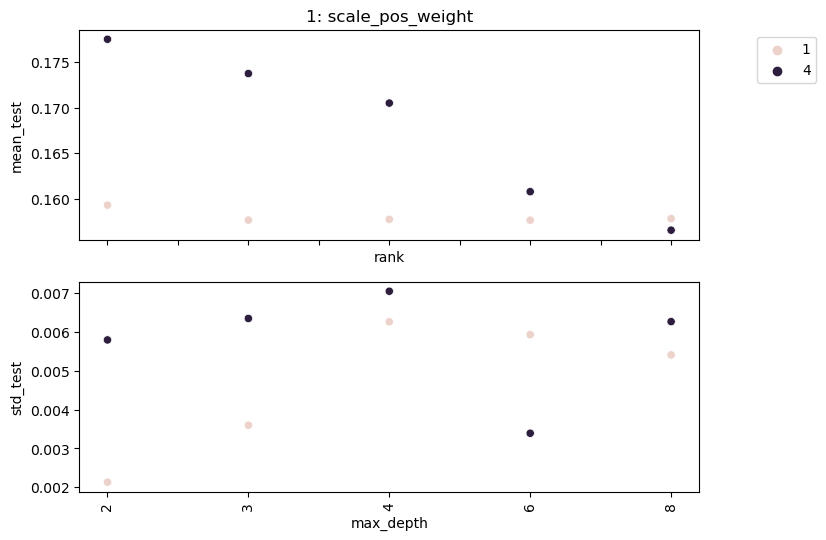

In [137]:
cv_helper.scatterplot('1', hue='scale_pos_weight', ys=['mean_test','std_test'], x_main='max_depth')

In [138]:
best_param = {'gamma': 0,
              'max_depth': 3,
              'min_child_weight': 1,
              'scale_pos_weight': 1,
              'n_estimators': 10000,
              'early_stopping_rounds': 50,
              'learning_rate': 0.1,
              'eval_metric': f1_eval_error}

In [142]:
clf = CV_xgboost()
clf.refit(X_train, y_train, best_param, kf=ShuffleSplit(n_splits=4))

[0]	validation_0-logloss:0.62676	validation_0-f1_eval_error:0.27680
[1]	validation_0-logloss:0.57285	validation_0-f1_eval_error:0.26032
[2]	validation_0-logloss:0.52814	validation_0-f1_eval_error:0.25472
[3]	validation_0-logloss:0.48969	validation_0-f1_eval_error:0.25234
[4]	validation_0-logloss:0.45687	validation_0-f1_eval_error:0.24884
[5]	validation_0-logloss:0.42828	validation_0-f1_eval_error:0.24299
[6]	validation_0-logloss:0.40310	validation_0-f1_eval_error:0.23404
[7]	validation_0-logloss:0.38221	validation_0-f1_eval_error:0.23692
[8]	validation_0-logloss:0.36356	validation_0-f1_eval_error:0.23620
[9]	validation_0-logloss:0.34648	validation_0-f1_eval_error:0.22866
[10]	validation_0-logloss:0.33218	validation_0-f1_eval_error:0.22561
[11]	validation_0-logloss:0.31983	validation_0-f1_eval_error:0.22374
[12]	validation_0-logloss:0.30874	validation_0-f1_eval_error:0.22121
[13]	validation_0-logloss:0.29845	validation_0-f1_eval_error:0.21450
[14]	validation_0-logloss:0.28901	validation

[119]	validation_0-logloss:0.18231	validation_0-f1_eval_error:0.17971
[120]	validation_0-logloss:0.18232	validation_0-f1_eval_error:0.17971
[121]	validation_0-logloss:0.18235	validation_0-f1_eval_error:0.17971
[122]	validation_0-logloss:0.18212	validation_0-f1_eval_error:0.17852
[123]	validation_0-logloss:0.18211	validation_0-f1_eval_error:0.17852
[124]	validation_0-logloss:0.18194	validation_0-f1_eval_error:0.17852
[125]	validation_0-logloss:0.18204	validation_0-f1_eval_error:0.17852
[126]	validation_0-logloss:0.18195	validation_0-f1_eval_error:0.17852
[127]	validation_0-logloss:0.18206	validation_0-f1_eval_error:0.17681
[128]	validation_0-logloss:0.18217	validation_0-f1_eval_error:0.17852
[129]	validation_0-logloss:0.18196	validation_0-f1_eval_error:0.17681
[130]	validation_0-logloss:0.18189	validation_0-f1_eval_error:0.17681
[131]	validation_0-logloss:0.18177	validation_0-f1_eval_error:0.17681
[132]	validation_0-logloss:0.18167	validation_0-f1_eval_error:0.17852
[133]	validation_0-l

[21]	validation_0-logloss:0.24816	validation_0-f1_eval_error:0.21093
[22]	validation_0-logloss:0.24447	validation_0-f1_eval_error:0.20544
[23]	validation_0-logloss:0.24087	validation_0-f1_eval_error:0.20789
[24]	validation_0-logloss:0.23676	validation_0-f1_eval_error:0.20362
[25]	validation_0-logloss:0.23413	validation_0-f1_eval_error:0.20362
[26]	validation_0-logloss:0.23181	validation_0-f1_eval_error:0.20362
[27]	validation_0-logloss:0.22887	validation_0-f1_eval_error:0.19940
[28]	validation_0-logloss:0.22574	validation_0-f1_eval_error:0.20181
[29]	validation_0-logloss:0.22401	validation_0-f1_eval_error:0.20301
[30]	validation_0-logloss:0.22242	validation_0-f1_eval_error:0.20301
[31]	validation_0-logloss:0.22023	validation_0-f1_eval_error:0.20240
[32]	validation_0-logloss:0.21898	validation_0-f1_eval_error:0.19880
[33]	validation_0-logloss:0.21704	validation_0-f1_eval_error:0.20298
[34]	validation_0-logloss:0.21495	validation_0-f1_eval_error:0.20298
[35]	validation_0-logloss:0.21398	

[140]	validation_0-logloss:0.18064	validation_0-f1_eval_error:0.17784
[141]	validation_0-logloss:0.18074	validation_0-f1_eval_error:0.18076
[142]	validation_0-logloss:0.18066	validation_0-f1_eval_error:0.18076
[143]	validation_0-logloss:0.18071	validation_0-f1_eval_error:0.18076
[144]	validation_0-logloss:0.18068	validation_0-f1_eval_error:0.18195
[145]	validation_0-logloss:0.18062	validation_0-f1_eval_error:0.17904
[146]	validation_0-logloss:0.18038	validation_0-f1_eval_error:0.17904
[147]	validation_0-logloss:0.18035	validation_0-f1_eval_error:0.18023
[148]	validation_0-logloss:0.18013	validation_0-f1_eval_error:0.18023
[149]	validation_0-logloss:0.18024	validation_0-f1_eval_error:0.17904
[150]	validation_0-logloss:0.18017	validation_0-f1_eval_error:0.17562
[151]	validation_0-logloss:0.18014	validation_0-f1_eval_error:0.17562
[152]	validation_0-logloss:0.18008	validation_0-f1_eval_error:0.17562
[153]	validation_0-logloss:0.18005	validation_0-f1_eval_error:0.17511
[154]	validation_0-l

[92]	validation_0-logloss:0.19252	validation_0-f1_eval_error:0.16304
[93]	validation_0-logloss:0.19212	validation_0-f1_eval_error:0.16304
[94]	validation_0-logloss:0.19198	validation_0-f1_eval_error:0.16304
[95]	validation_0-logloss:0.19209	validation_0-f1_eval_error:0.16349
[96]	validation_0-logloss:0.19163	validation_0-f1_eval_error:0.16190
[97]	validation_0-logloss:0.19154	validation_0-f1_eval_error:0.16146
[98]	validation_0-logloss:0.19142	validation_0-f1_eval_error:0.16103
[99]	validation_0-logloss:0.19128	validation_0-f1_eval_error:0.15946
[100]	validation_0-logloss:0.19093	validation_0-f1_eval_error:0.15946
[101]	validation_0-logloss:0.19085	validation_0-f1_eval_error:0.15790
[102]	validation_0-logloss:0.19065	validation_0-f1_eval_error:0.15946
[103]	validation_0-logloss:0.19064	validation_0-f1_eval_error:0.15946
[104]	validation_0-logloss:0.19063	validation_0-f1_eval_error:0.15832
[105]	validation_0-logloss:0.19037	validation_0-f1_eval_error:0.15832
[106]	validation_0-logloss:0

[60]	validation_0-logloss:0.20138	validation_0-f1_eval_error:0.17421
[61]	validation_0-logloss:0.20106	validation_0-f1_eval_error:0.17421
[62]	validation_0-logloss:0.20055	validation_0-f1_eval_error:0.17260
[63]	validation_0-logloss:0.20017	validation_0-f1_eval_error:0.17374
[64]	validation_0-logloss:0.19977	validation_0-f1_eval_error:0.17260
[65]	validation_0-logloss:0.19948	validation_0-f1_eval_error:0.17260
[66]	validation_0-logloss:0.19897	validation_0-f1_eval_error:0.17260
[67]	validation_0-logloss:0.19858	validation_0-f1_eval_error:0.17421
[68]	validation_0-logloss:0.19824	validation_0-f1_eval_error:0.17260
[69]	validation_0-logloss:0.19806	validation_0-f1_eval_error:0.17374
[70]	validation_0-logloss:0.19765	validation_0-f1_eval_error:0.17053
[71]	validation_0-logloss:0.19696	validation_0-f1_eval_error:0.16940
[72]	validation_0-logloss:0.19659	validation_0-f1_eval_error:0.17053
[73]	validation_0-logloss:0.19625	validation_0-f1_eval_error:0.17053
[74]	validation_0-logloss:0.19603	

[77]	validation_0-logloss:0.19163	validation_0-f1_eval_error:0.16894
[78]	validation_0-logloss:0.19136	validation_0-f1_eval_error:0.17120
[79]	validation_0-logloss:0.19112	validation_0-f1_eval_error:0.17279
[80]	validation_0-logloss:0.19104	validation_0-f1_eval_error:0.17279
[81]	validation_0-logloss:0.19078	validation_0-f1_eval_error:0.17120
[82]	validation_0-logloss:0.19018	validation_0-f1_eval_error:0.16780
[83]	validation_0-logloss:0.19000	validation_0-f1_eval_error:0.16780
[84]	validation_0-logloss:0.18982	validation_0-f1_eval_error:0.16894
[85]	validation_0-logloss:0.18957	validation_0-f1_eval_error:0.16894
[86]	validation_0-logloss:0.18901	validation_0-f1_eval_error:0.17166
[87]	validation_0-logloss:0.18890	validation_0-f1_eval_error:0.17166
[88]	validation_0-logloss:0.18868	validation_0-f1_eval_error:0.17326
[89]	validation_0-logloss:0.18821	validation_0-f1_eval_error:0.17213
[90]	validation_0-logloss:0.18818	validation_0-f1_eval_error:0.17213
[91]	validation_0-logloss:0.18791	

[195]	validation_0-logloss:0.18039	validation_0-f1_eval_error:0.15354
[196]	validation_0-logloss:0.18027	validation_0-f1_eval_error:0.15200
[197]	validation_0-logloss:0.18032	validation_0-f1_eval_error:0.15200
[198]	validation_0-logloss:0.18038	validation_0-f1_eval_error:0.15200
[199]	validation_0-logloss:0.18042	validation_0-f1_eval_error:0.15200
[200]	validation_0-logloss:0.18045	validation_0-f1_eval_error:0.15200
[201]	validation_0-logloss:0.18030	validation_0-f1_eval_error:0.15200
[202]	validation_0-logloss:0.18014	validation_0-f1_eval_error:0.15200
[203]	validation_0-logloss:0.18020	validation_0-f1_eval_error:0.15200
[204]	validation_0-logloss:0.18014	validation_0-f1_eval_error:0.15087
[205]	validation_0-logloss:0.18010	validation_0-f1_eval_error:0.15087
[206]	validation_0-logloss:0.18004	validation_0-f1_eval_error:0.15087
[207]	validation_0-logloss:0.18004	validation_0-f1_eval_error:0.15087
[208]	validation_0-logloss:0.18002	validation_0-f1_eval_error:0.15087
[209]	validation_0-l

[51]	validation_0-logloss:0.20311	validation_0-f1_eval_error:0.18119
[52]	validation_0-logloss:0.20211	validation_0-f1_eval_error:0.17793
[53]	validation_0-logloss:0.20149	validation_0-f1_eval_error:0.17793
[54]	validation_0-logloss:0.20089	validation_0-f1_eval_error:0.17680
[55]	validation_0-logloss:0.20067	validation_0-f1_eval_error:0.17793
[56]	validation_0-logloss:0.20005	validation_0-f1_eval_error:0.17793
[57]	validation_0-logloss:0.19923	validation_0-f1_eval_error:0.17793
[58]	validation_0-logloss:0.19896	validation_0-f1_eval_error:0.17956
[59]	validation_0-logloss:0.19825	validation_0-f1_eval_error:0.17728
[60]	validation_0-logloss:0.19793	validation_0-f1_eval_error:0.17842
[61]	validation_0-logloss:0.19692	validation_0-f1_eval_error:0.17566
[62]	validation_0-logloss:0.19615	validation_0-f1_eval_error:0.17566
[63]	validation_0-logloss:0.19590	validation_0-f1_eval_error:0.17680
[64]	validation_0-logloss:0.19575	validation_0-f1_eval_error:0.17793
[65]	validation_0-logloss:0.19548	

[169]	validation_0-logloss:0.18200	validation_0-f1_eval_error:0.15860
[170]	validation_0-logloss:0.18200	validation_0-f1_eval_error:0.15860
[171]	validation_0-logloss:0.18193	validation_0-f1_eval_error:0.15860
[172]	validation_0-logloss:0.18188	validation_0-f1_eval_error:0.15705
[173]	validation_0-logloss:0.18180	validation_0-f1_eval_error:0.15550
[174]	validation_0-logloss:0.18178	validation_0-f1_eval_error:0.15550
[175]	validation_0-logloss:0.18183	validation_0-f1_eval_error:0.15550
[176]	validation_0-logloss:0.18170	validation_0-f1_eval_error:0.15395
[177]	validation_0-logloss:0.18163	validation_0-f1_eval_error:0.15550
[178]	validation_0-logloss:0.18147	validation_0-f1_eval_error:0.15550
[179]	validation_0-logloss:0.18146	validation_0-f1_eval_error:0.15550
[180]	validation_0-logloss:0.18142	validation_0-f1_eval_error:0.15550
[181]	validation_0-logloss:0.18158	validation_0-f1_eval_error:0.15550
[182]	validation_0-logloss:0.18151	validation_0-f1_eval_error:0.15395
[183]	validation_0-l

[75]	validation_0-logloss:0.19333	validation_0-f1_eval_error:0.16340
[76]	validation_0-logloss:0.19291	validation_0-f1_eval_error:0.16340
[77]	validation_0-logloss:0.19275	validation_0-f1_eval_error:0.16340
[78]	validation_0-logloss:0.19248	validation_0-f1_eval_error:0.16340
[79]	validation_0-logloss:0.19224	validation_0-f1_eval_error:0.16340
[80]	validation_0-logloss:0.19185	validation_0-f1_eval_error:0.16230
[81]	validation_0-logloss:0.19176	validation_0-f1_eval_error:0.16449
[82]	validation_0-logloss:0.19160	validation_0-f1_eval_error:0.16558
[83]	validation_0-logloss:0.19155	validation_0-f1_eval_error:0.16601
[84]	validation_0-logloss:0.19135	validation_0-f1_eval_error:0.16492
[85]	validation_0-logloss:0.19106	validation_0-f1_eval_error:0.16340
[86]	validation_0-logloss:0.19092	validation_0-f1_eval_error:0.16340
[87]	validation_0-logloss:0.19076	validation_0-f1_eval_error:0.16340
[88]	validation_0-logloss:0.19046	validation_0-f1_eval_error:0.16449
[89]	validation_0-logloss:0.19019	

[64]	validation_0-logloss:0.19831	validation_0-f1_eval_error:0.16645
[65]	validation_0-logloss:0.19759	validation_0-f1_eval_error:0.16492
[66]	validation_0-logloss:0.19706	validation_0-f1_eval_error:0.16645
[67]	validation_0-logloss:0.19646	validation_0-f1_eval_error:0.16645
[68]	validation_0-logloss:0.19625	validation_0-f1_eval_error:0.16492
[69]	validation_0-logloss:0.19576	validation_0-f1_eval_error:0.16340
[70]	validation_0-logloss:0.19537	validation_0-f1_eval_error:0.16449
[71]	validation_0-logloss:0.19476	validation_0-f1_eval_error:0.16449
[72]	validation_0-logloss:0.19449	validation_0-f1_eval_error:0.16449
[73]	validation_0-logloss:0.19438	validation_0-f1_eval_error:0.16558
[74]	validation_0-logloss:0.19384	validation_0-f1_eval_error:0.16340
[75]	validation_0-logloss:0.19333	validation_0-f1_eval_error:0.16340
[76]	validation_0-logloss:0.19291	validation_0-f1_eval_error:0.16340
[77]	validation_0-logloss:0.19275	validation_0-f1_eval_error:0.16340
[78]	validation_0-logloss:0.19248	

In [143]:
f1_score(clf.predict(X_test), y_test)

0.8526100307062435

In [144]:
for i in range(4):
    print(f1_score(clf.clfs[i].predict(X_test), y_test))

0.8523421588594704
0.8505154639175257
0.8526422764227641
0.8482972136222912
